## 1.0 Project: To Vaccinate or Not to Vaccinate: It’s not a Question

Work has already begun towards developing a COVID-19 vaccine. From measles to the common flu, vaccines have lowered the risk of illness and death, and have saved countless lives around the world. Unfortunately in some countries, the 'anti-vaxxer' movement has led to lower rates of vaccination and new outbreaks of old diseases.

Although it may be many months before we see COVID-19 vaccines available on a global scale, it is important to monitor public sentiment towards vaccinations now and especially in the future when COVID-19 vaccines are offered to the public. The anti-vaccination sentiment could pose a serious threat to the global efforts to get COVID-19 under control in the long term.

### 1.1 The Problem

The objective of this challenge is to develop a machine learning model to assess if a Twitter post related to vaccinations is positive, neutral, or negative. This solution could help governments and other public health actors monitor public sentiment towards COVID-19 vaccinations and help improve public health policy, vaccine communication strategies, and vaccination programs across the world.

### 1.2 Data Description

The data comes from tweets collected and classified through Crowdbreaks.org [Muller, Martin M., and Marcel Salathe. "Crowdbreaks: Tracking Health Trends Using Public Social Media Data and Crowdsourcing." Frontiers in public health 7 (2019).]. Tweets have been classified as __pro-vaccine (1), neutral (0) or anti-vaccine (-1)__. The tweets have had usernames and web addresses removed.

The objective of this challenge is to develop a machine learning model to assess if a twitter post that is related to vaccinations is positive, neutral, or negative.

#### 1.2.1 Variable definition:

- __tweet_id__: Unique identifier of the tweet
- __safe_tweet__: Text contained in the tweet. Some sensitive information has been removed like usernames and urls
- __label__: Sentiment of the tweet (-1 for negative, 0 for neutral, 1 for positive)
- __agreement__: The tweets were labeled by three people. Agreement indicates the percentage of the three reviewers that agreed on the given label. You may use this column in your training, but agreement data will not be shared for the test set.

Files available for download are:

- __Train.csv__ - Labelled tweets on which to train your model
- __Test.csv__ - Tweets that you must classify using your trained model
- __SampleSubmission.csv__ - is an example of what your submission file should look like. The order of the rows does not matter, but the names of the ID must be correct. Values in the 'label' column should range between -1 and 1.


From https://zindi.africa/hackathons/to-vaccinate-or-not-to-vaccinate-its-not-a-question

### 2.0 Setting the environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re

from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error

from IPython.display import display
%matplotlib inline
sns.set_style('whitegrid')
pd.options.display.max_colwidth = 100

import os
import warnings
warnings.filterwarnings('ignore')


### 2.1 Loading the datasets

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
display('Train')
display(train.head())
display('Test')
display(test.head())

'Train'

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the ID...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something that won't secretly kill him years down the line t...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #...,0.0,1.0


'Test'

,tweet_id,safe_text
0,00BHHHP1,"<user> <user> ... &amp; 4 a vaccine given 2 healthy peeps, FDA think just not worth the AE risk ..."
1,00UNMD0E,Students starting school without whooping cough vaccinations <url> #scpick
2,01AXPTJF,"I'm kinda over every ep of <user> being ""ripped from the headlines."" Measles? Let's get back to ..."
3,01HOEQJW,How many innocent children die for lack of vaccination each year? Around 1.5 million. Too bad al...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though risk is low: Federal officials said Wednesday the..."


In [4]:
train.shape

(10001, 4)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
tweet_id     10001 non-null object
safe_text    10001 non-null object
label        10000 non-null float64
agreement    9999 non-null float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [6]:
test.shape

(5177, 2)

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
tweet_id     5177 non-null object
safe_text    5176 non-null object
dtypes: object(2)
memory usage: 81.0+ KB


In [8]:
test.isnull().sum()

tweet_id     0
safe_text    1
dtype: int64

In [9]:
test = test.dropna(axis = 0) 

In [10]:
test.isnull().sum()

tweet_id     0
safe_text    0
dtype: int64

In [11]:
test.to_csv('test_clean.csv', index=False)

In [12]:
train.isnull().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [13]:
train = train.dropna(axis = 0) 

In [14]:
train.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [15]:
display('Train shape')
display(train.shape)
display('Test shape')
display(test.shape)

'Train shape'

(9999, 4)

'Test shape'

(5176, 2)

### 3.0 Text Processing

#### 3.1 Combining Datasets

In [16]:
#Combining the datasets
data = train.append(test, ignore_index=True)
data.head()

,agreement,label,safe_text,tweet_id
0,1.0,0.0,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,CL1KWCMY
1,1.0,1.0,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the ID...,E3303EME
2,1.0,-1.0,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",M4IVFSMS
3,1.0,-1.0,I mean if they immunize my kid with something that won't secretly kill him years down the line t...,1DR6ROZ4
4,1.0,0.0,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #...,J77ENIIE


In [17]:
data.tail()

,agreement,label,safe_text,tweet_id
15170,NaN,NaN,jenny mccarthy is on new years rockin eve. what has she done lately besides not vaccinate her ki...,ZXVVNC5O
15171,NaN,NaN,Measles reported in Clark Co. for 1st time since 2011 <url>,ZYIANVI8
15172,NaN,NaN,"<user> issues alert regarding Measles in TX. Keep your DDx up to date, people! #Emergencymedicine",ZYITEHAH
15173,NaN,NaN,I can't believe people don't vaccinate their kids! I've been vaccinated for everything and then ...,ZZ3BMBTG
15174,NaN,NaN,"""<user> Alternatives to #Flu Vaccine <url> #natural #health"" A good read with a few new tips &a...",ZZIYCVNH


In [18]:
data.shape

(15175, 4)

#### 3.2 Changing 'safe_text' column to lower case

In [19]:
#changing the column datatype to string
data['safe_text'] = data['safe_text'].astype(str)   

#making all my safe_text to be lower case
data['clean_safe_text'] = data['safe_text'].apply(lambda x: x.lower())
data.head()

,agreement,label,safe_text,tweet_id,clean_safe_text
0,1.0,0.0,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,CL1KWCMY,me &amp; the big homie meanboy3000 #meanboy #mb #mbs #mmr #stegmanlife @ stegman st. <url>
1,1.0,1.0,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the ID...,E3303EME,i'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the id...
2,1.0,-1.0,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",M4IVFSMS,"#whatcausesautism vaccines, do not vaccinate your child"
3,1.0,-1.0,I mean if they immunize my kid with something that won't secretly kill him years down the line t...,1DR6ROZ4,i mean if they immunize my kid with something that won't secretly kill him years down the line t...
4,1.0,0.0,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #...,J77ENIIE,thanks to <user> catch me performing at la nuit nyc 1134 1st ave. show starts at 6! #jennifair #...


#### 3.3 Removing twitter handles

In [20]:
#function for removing <user> from text
def remove_user(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [21]:
# remove <user>
data['clean_safe_text'] = np.vectorize(remove_user)(data['clean_safe_text'], "<[\w]*>")
data.head()

,agreement,label,safe_text,tweet_id,clean_safe_text
0,1.0,0.0,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,CL1KWCMY,me &amp; the big homie meanboy3000 #meanboy #mb #mbs #mmr #stegmanlife @ stegman st.
1,1.0,1.0,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the ID...,E3303EME,i'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the id...
2,1.0,-1.0,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",M4IVFSMS,"#whatcausesautism vaccines, do not vaccinate your child"
3,1.0,-1.0,I mean if they immunize my kid with something that won't secretly kill him years down the line t...,1DR6ROZ4,i mean if they immunize my kid with something that won't secretly kill him years down the line t...
4,1.0,0.0,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #...,J77ENIIE,thanks to catch me performing at la nuit nyc 1134 1st ave. show starts at 6! #jennifair #mmr…


In [22]:
data.tail()

,agreement,label,safe_text,tweet_id,clean_safe_text
15170,NaN,NaN,jenny mccarthy is on new years rockin eve. what has she done lately besides not vaccinate her ki...,ZXVVNC5O,jenny mccarthy is on new years rockin eve. what has she done lately besides not vaccinate her ki...
15171,NaN,NaN,Measles reported in Clark Co. for 1st time since 2011 <url>,ZYIANVI8,measles reported in clark co. for 1st time since 2011
15172,NaN,NaN,"<user> issues alert regarding Measles in TX. Keep your DDx up to date, people! #Emergencymedicine",ZYITEHAH,"issues alert regarding measles in tx. keep your ddx up to date, people! #emergencymedicine"
15173,NaN,NaN,I can't believe people don't vaccinate their kids! I've been vaccinated for everything and then ...,ZZ3BMBTG,i can't believe people don't vaccinate their kids! i've been vaccinated for everything and then ...
15174,NaN,NaN,"""<user> Alternatives to #Flu Vaccine <url> #natural #health"" A good read with a few new tips &a...",ZZIYCVNH,""" alternatives to #flu vaccine #natural #health"" a good read with a few new tips &amp; many we..."


#### 3.4 Removing punctuations, number and special characters

In [23]:
# remove special characters, numbers, punctuations
data['clean_safe_text'] = data['clean_safe_text'].str.replace("[^a-zA-Z#]", " ")
data.head()

,agreement,label,safe_text,tweet_id,clean_safe_text
0,1.0,0.0,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,CL1KWCMY,me amp the big homie meanboy #meanboy #mb #mbs #mmr #stegmanlife stegman st
1,1.0,1.0,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the ID...,E3303EME,i m thinking of devoting my career to proving autism isn t caused by vaccines due to the id...
2,1.0,-1.0,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",M4IVFSMS,#whatcausesautism vaccines do not vaccinate your child
3,1.0,-1.0,I mean if they immunize my kid with something that won't secretly kill him years down the line t...,1DR6ROZ4,i mean if they immunize my kid with something that won t secretly kill him years down the line t...
4,1.0,0.0,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #...,J77ENIIE,thanks to catch me performing at la nuit nyc st ave show starts at #jennifair #mmr


In [24]:
 #find what emoticons are used in our dataset
import re
tweets_text = data.clean_safe_text.str.cat()
emos = set(re.findall(r" ([xX:;][-']?.) ",tweets_text))
emos_count = []
for emo in emos:
    emos_count.append((tweets_text.count(emo), emo))
sorted(emos_count,reverse=True)

[(618, 'x '), (480, 'xp'), (131, 'xx'), (8, 'xd')]

#### 3.5 Removing short words

In [25]:
#remove words with length of 3 or less 
data['clean_safe_text'] = data['clean_safe_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data.head()

,agreement,label,safe_text,tweet_id,clean_safe_text
0,1.0,0.0,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,CL1KWCMY,homie meanboy #meanboy #mbs #mmr #stegmanlife stegman
1,1.0,1.0,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the ID...,E3303EME,thinking devoting career proving autism caused vaccines idiotic posts seen about world autism
2,1.0,-1.0,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",M4IVFSMS,#whatcausesautism vaccines vaccinate your child
3,1.0,-1.0,I mean if they immunize my kid with something that won't secretly kill him years down the line t...,1DR6ROZ4,mean they immunize with something that secretly kill years down line then trust that
4,1.0,0.0,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #...,J77ENIIE,thanks catch performing nuit show starts #jennifair #mmr


In [26]:
import nltk
from nltk.corpus import stopwords
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [27]:
def stop_words_removal(df):
    data['clean_safe_text'] = df['clean_safe_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    print(data['clean_safe_text'].head())

In [28]:
from textblob import TextBlob

In [29]:
def spell_correction(df):
    return data['clean_safe_text'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [30]:
spell_correction(data)

0                                              home meanly #meanly #mrs #mr #stegmanlife sherman
1    thinking devoting career proving cutis caused vaccines idiotic posts seen about world cutis
2                                                  #whatcausesautism vaccines vaccine your child
3           mean they immunise with something that secretly kill years down line then trust that
4                                        thanks catch performing suit show starts #jennifair #mr
Name: clean_safe_text, dtype: object

#### 3.5 Stemming and Lemmatization

#### 3.6 Tokenization

In [31]:
tokenized_text = data['clean_safe_text'].apply(lambda x: x.split())
tokenized_text.head()

0                                          [homie, meanboy, #meanboy, #mbs, #mmr, #stegmanlife, stegman]
1    [thinking, devoting, career, proving, autism, caused, vaccines, idiotic, posts, seen, about, wor...
2                                                  [#whatcausesautism, vaccines, vaccinate, your, child]
3    [mean, they, immunize, with, something, that, secretly, kill, years, down, line, then, trust, that]
4                                      [thanks, catch, performing, nuit, show, starts, #jennifair, #mmr]
Name: clean_safe_text, dtype: object

In [32]:
#Lemmatization
'''
lemmatizing = WordNetLemmatizer()
data['lemmatized_text'] = data['tokenized_text'].apply(lambda x: ' '.join([lemmatizing.lemmatize(i) for i in x]))
data.head(10)
'''

"\nlemmatizing = WordNetLemmatizer()\ndata['lemmatized_text'] = data['tokenized_text'].apply(lambda x: ' '.join([lemmatizing.lemmatize(i) for i in x]))\ndata.head(10)\n"

In [33]:
#Stemming

stemmer = PorterStemmer()

tokenized_text= tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_text.head()


0                                      [homi, meanboy, #meanboy, #mb, #mmr, #stegmanlif, stegman]
1    [think, devot, career, prove, autism, caus, vaccin, idiot, post, seen, about, world, autism]
2                                                   [#whatcausesaut, vaccin, vaccin, your, child]
3    [mean, they, immun, with, someth, that, secretli, kill, year, down, line, then, trust, that]
4                                    [thank, catch, perform, nuit, show, start, #jennifair, #mmr]
Name: clean_safe_text, dtype: object

In [34]:
for i in range(len(tokenized_text)):
    tokenized_text[i] = ' '.join(tokenized_text[i])

data['clean_safe_text'] = tokenized_text
data.head()

,agreement,label,safe_text,tweet_id,clean_safe_text
0,1.0,0.0,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,CL1KWCMY,homi meanboy #meanboy #mb #mmr #stegmanlif stegman
1,1.0,1.0,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the ID...,E3303EME,think devot career prove autism caus vaccin idiot post seen about world autism
2,1.0,-1.0,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",M4IVFSMS,#whatcausesaut vaccin vaccin your child
3,1.0,-1.0,I mean if they immunize my kid with something that won't secretly kill him years down the line t...,1DR6ROZ4,mean they immun with someth that secretli kill year down line then trust that
4,1.0,0.0,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #...,J77ENIIE,thank catch perform nuit show start #jennifair #mmr


### 4.0 Data Visualization

#### 4.1 Data Exploration

In [35]:
data[data.clean_safe_text.isnull()]

,agreement,label,safe_text,tweet_id,clean_safe_text


In [36]:
data.shape

(15175, 5)

In [37]:
data.shape

(15175, 5)

In [38]:

data['clean_safe_text_length'] = data['clean_safe_text'].apply(len)
data.head()

,agreement,label,safe_text,tweet_id,clean_safe_text,clean_safe_text_length
0,1.0,0.0,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,CL1KWCMY,homi meanboy #meanboy #mb #mmr #stegmanlif stegman,50
1,1.0,1.0,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the ID...,E3303EME,think devot career prove autism caus vaccin idiot post seen about world autism,78
2,1.0,-1.0,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",M4IVFSMS,#whatcausesaut vaccin vaccin your child,39
3,1.0,-1.0,I mean if they immunize my kid with something that won't secretly kill him years down the line t...,1DR6ROZ4,mean they immun with someth that secretli kill year down line then trust that,77
4,1.0,0.0,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #...,J77ENIIE,thank catch perform nuit show start #jennifair #mmr,51


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15175 entries, 0 to 15174
Data columns (total 6 columns):
agreement                 9999 non-null float64
label                     9999 non-null float64
safe_text                 15175 non-null object
tweet_id                  15175 non-null object
clean_safe_text           15175 non-null object
clean_safe_text_length    15175 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 711.5+ KB


In [40]:
data['label'].value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

In [41]:
data['agreement'].value_counts()

1.000000    5866
0.666667    3894
0.333333     239
Name: agreement, dtype: int64

#### 4.1 Common words

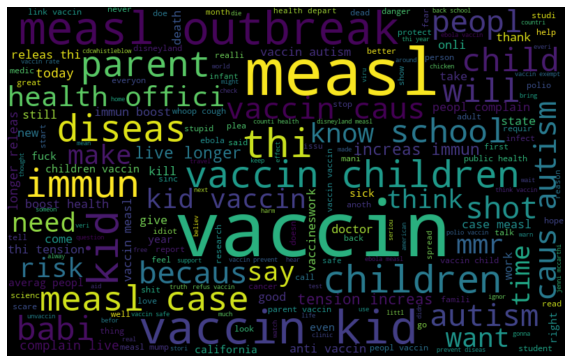

In [42]:
#plotting all words
all_words = ' '.join([text for text in data['clean_safe_text']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

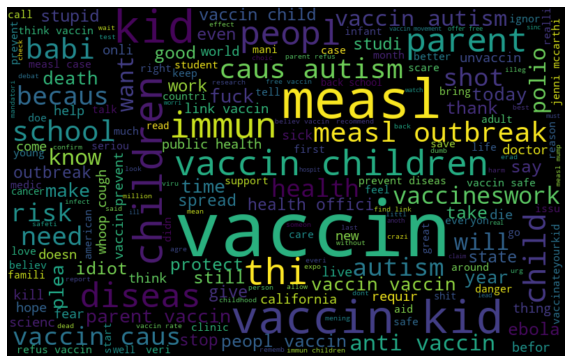

In [43]:
#plotting pro-vaccine words
pro_vaccine_words = ' '.join([text for text in data['clean_safe_text'][data['label']==1.0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pro_vaccine_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

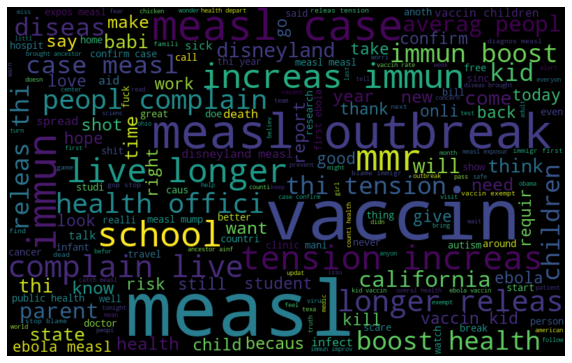

In [44]:
#plotting neutral words
neutral_words = ' '.join([text for text in data['clean_safe_text'][data['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neutral_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

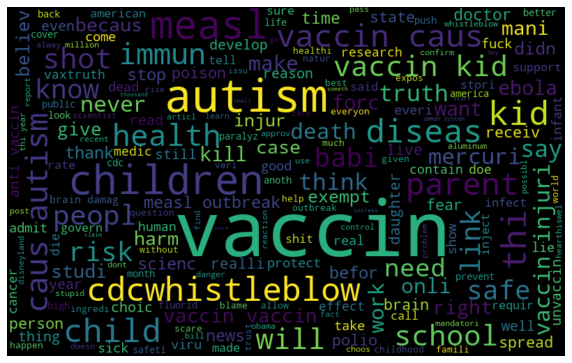

In [45]:
#plotting anti-vaccine words
anti_vaccine_words = ' '.join([text for text in data['clean_safe_text'][data['label']==-1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(anti_vaccine_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### 4.2 Hashtags

In [46]:
# function to collect hashtags
def get_hashtag(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [47]:
# extracting hashtags from pro_vaccine texts

pro_vaccine_ht = get_hashtag(data['clean_safe_text'][data['label'] == 1])

# extracting hashtags from neutral texts
neutral_ht = get_hashtag(data['clean_safe_text'][data['label'] == 0])

# extracting hashtags from anti_vaccine texts
anti_vaccine_ht = get_hashtag(data['clean_safe_text'][data['label'] == -1])


# unnesting list
pro_vaccine_ht= sum(pro_vaccine_ht,[])
neutral_ht = sum(neutral_ht,[])
anti_vaccine_ht= sum(anti_vaccine_ht,[])

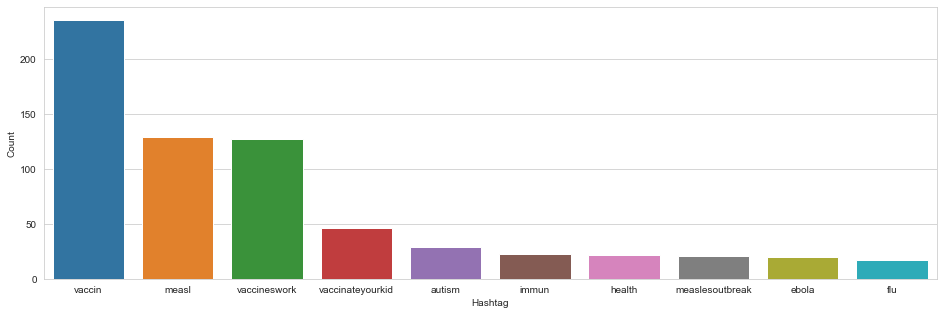

In [48]:
#plot pro_vaccine texts

a = nltk.FreqDist(pro_vaccine_ht)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

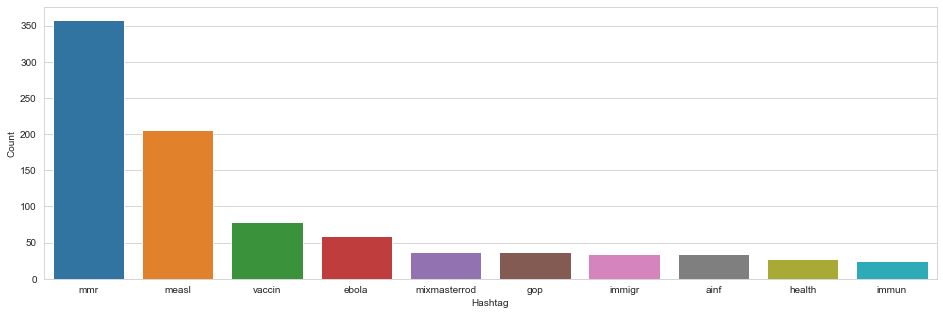

In [49]:
#plot neutral texts

a = nltk.FreqDist(neutral_ht)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

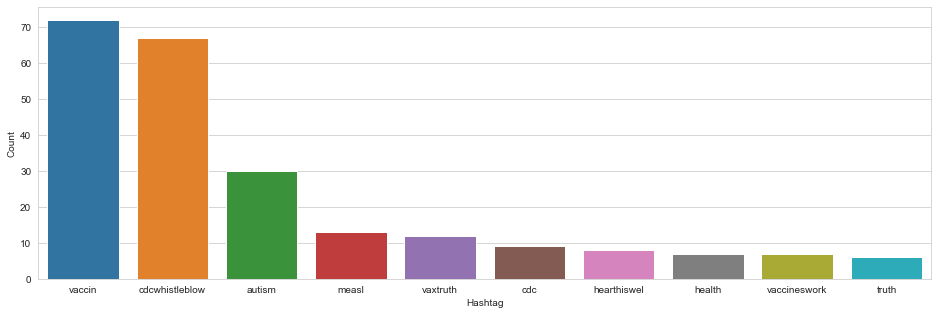

In [50]:
#plot anti_vaccine texts

a = nltk.FreqDist(anti_vaccine_ht)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### 5.0 Feature Extraction

In [51]:
data.shape

(15175, 6)

In [52]:
data.head(135)

,agreement,label,safe_text,tweet_id,clean_safe_text,clean_safe_text_length
0,1.000000,0.0,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,CL1KWCMY,homi meanboy #meanboy #mb #mmr #stegmanlif stegman,50
1,1.000000,1.0,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the ID...,E3303EME,think devot career prove autism caus vaccin idiot post seen about world autism,78
2,1.000000,-1.0,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",M4IVFSMS,#whatcausesaut vaccin vaccin your child,39
3,1.000000,-1.0,I mean if they immunize my kid with something that won't secretly kill him years down the line t...,1DR6ROZ4,mean they immun with someth that secretli kill year down line then trust that,77
4,1.000000,0.0,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #...,J77ENIIE,thank catch perform nuit show start #jennifair #mmr,51
...,...,...,...,...,...,...
130,1.000000,0.0,Editorial: Remove 'philosophical' exemption from vaccine requirements for school entry: Michigan...,6MKACF23,editori remov philosoph exempt from vaccin requir school entri michigan danger,78
131,0.666667,0.0,"<user> <user> <user> <user> <user> Even with the vaccine, your child is still at risk of catchin...",6SQPLPAL,even with vaccin your child still risk catch diseas,51
132,1.000000,1.0,<user> <user> <user> parents would no longer be able to rely on the herd immunity of protected c...,XPBFJJBT,parent would longer abl reli herd immun protect children,56
133,1.000000,-1.0,I honestly don't believe in immunization. \nNow they passed a new law that starting this year we...,4KEP2GOM,honestli believ immun they pass that start thi year need specif shot into school,80


In [53]:
# resetting index 
data.reset_index(inplace = True) 

In [54]:
data_copy = data.copy()

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15175 entries, 0 to 15174
Data columns (total 7 columns):
index                     15175 non-null int64
agreement                 9999 non-null float64
label                     9999 non-null float64
safe_text                 15175 non-null object
tweet_id                  15175 non-null object
clean_safe_text           15175 non-null object
clean_safe_text_length    15175 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 830.0+ KB


In [56]:
data.drop(columns = 'agreement', inplace=True)

In [57]:
data.drop(columns = 'clean_safe_text_length', inplace=True)

In [58]:
data.head()

,index,label,safe_text,tweet_id,clean_safe_text
0,0,0.0,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,CL1KWCMY,homi meanboy #meanboy #mb #mmr #stegmanlif stegman
1,1,1.0,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the ID...,E3303EME,think devot career prove autism caus vaccin idiot post seen about world autism
2,2,-1.0,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",M4IVFSMS,#whatcausesaut vaccin vaccin your child
3,3,-1.0,I mean if they immunize my kid with something that won't secretly kill him years down the line t...,1DR6ROZ4,mean they immun with someth that secretli kill year down line then trust that
4,4,0.0,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #...,J77ENIIE,thank catch perform nuit show start #jennifair #mmr


In [59]:
data.isnull().sum()

index                 0
label              5176
safe_text             0
tweet_id              0
clean_safe_text       0
dtype: int64

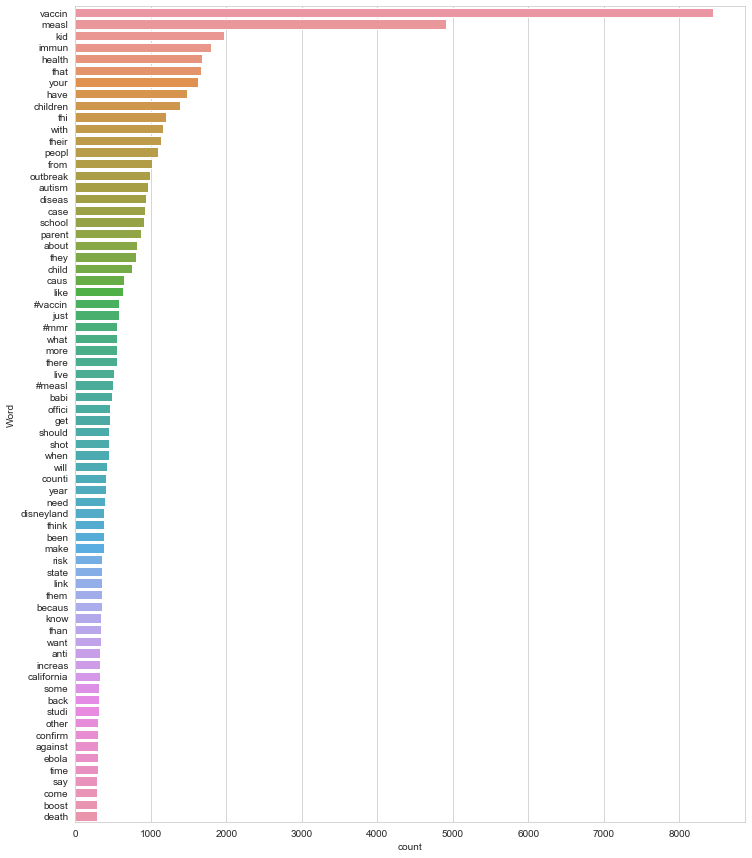

In [60]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(data['clean_safe_text'], 70)

In [61]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

data['clean_safe_text'] = data['clean_safe_text'].apply(lambda x: remove_stopwords(x))

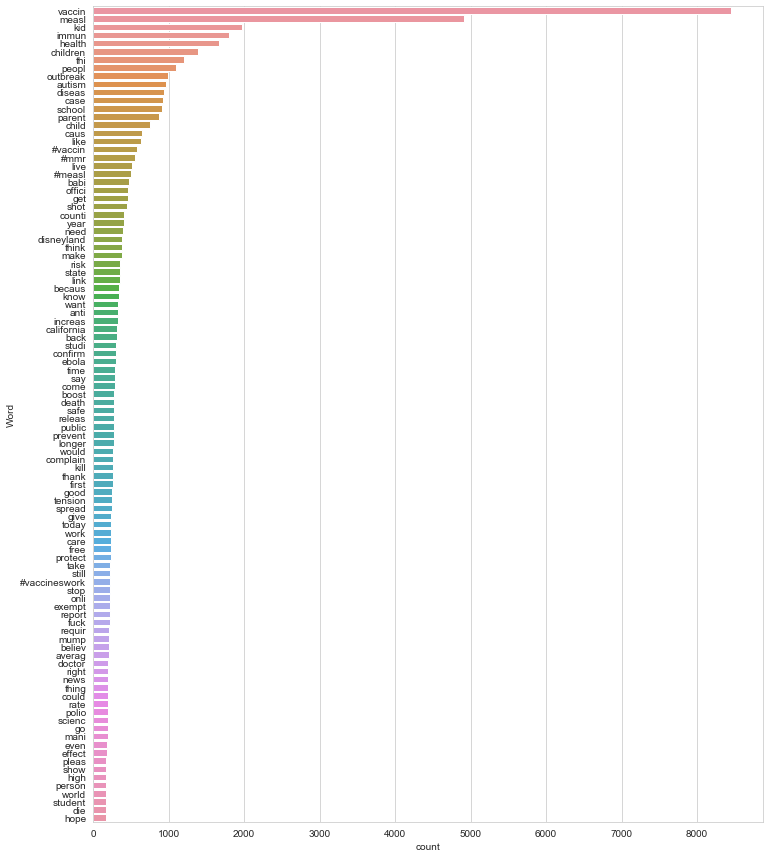

In [62]:
freq_words(data['clean_safe_text'], 100)

In [63]:
freq = pd.Series(' '.join(data['clean_safe_text']).split()).value_counts()[:10]
freq

vaccin      8449
measl       4913
kid         1974
immun       1800
health      1673
children    1382
thi         1206
peopl       1093
outbreak     985
autism       958
dtype: int64

In [64]:
freq = pd.Series(' '.join(data['clean_safe_text']).split()).value_counts()[-10:]
freq

#truthbetold        1
atanu               1
newscast            1
#teamhartwel        1
promiscu            1
#zombiezymplex      1
mucha               1
cedar               1
#morallybankrupt    1
thepalac            1
dtype: int64

In [65]:
def rare_words_removal(df):
    data['clean_safe_text'] = data['clean_safe_text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    print(data['clean_safe_text'].head())

In [66]:
rare_words_removal(data)

0                          homi meanboy #meanboy #mb #mmr #stegmanlif stegman
1    think devot career prove autism caus vaccin idiot post seen world autism
2                                          #whatcausesaut vaccin vaccin child
3                             mean immun someth secretli kill year line trust
4                         thank catch perform nuit show start #jennifair #mmr
Name: clean_safe_text, dtype: object


## Models

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(binary = False, max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=1000, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [68]:

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(data['clean_safe_text'])
bow

<15175x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 89080 stored elements in Compressed Sparse Row format>

In [69]:
# Importing library
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=5, max_features=1000, stop_words='english')
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=1000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [70]:
#Using TF-IDF
tfidf = tfidf_vectorizer.fit_transform(data['clean_safe_text'])
tfidf

<15175x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 89079 stored elements in Compressed Sparse Row format>

### 6.0 Building the model

#### 3.1 Using Bag of words features

In [71]:

train_w = bow[:9999,:]
test_w = bow[9999:,:]

# splitting data into training and validation set
xtrain_w, xvalid_w, ytrain, yvalid = train_test_split(train_w, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_w, ytrain) # training the model

prediction1 = lreg.predict_proba(xvalid_w) # predicting on the validation set
prediction_int = prediction1[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

#f1_score(yvalid, prediction_int) # calculating f1 score

In [72]:
test_pred = lreg.predict_proba(test_w)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['tweet_id','label']]
submission.to_csv('sub_lreg_w2.csv', index=False) # writing data to a CSV file

In [73]:
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

In [74]:
# Fit on training set only.
#scaler.fit(train_w)

sc = StandardScaler(with_mean=False)
X_train_sc = sc.fit(train_w)
train_w = X_train_sc.transform(train_w)
test_w = X_train_sc.transform(test_w)

#### Using TF_IDF features

In [97]:
train_tfidf = tfidf[:10001,:]
test_tfidf = tfidf[10001:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction_ = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction_[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

#f1_score(yvalid, prediction_int)

In [76]:
test_pred = lreg.predict_proba(test_w)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['tweet_id','label']]
submission.to_csv('sub_lreg_tf10000.csv', index=False) # writing data to a CSV file

### SDGClassifier

In [77]:
clf = SGDClassifier(loss="modified_huber", penalty="l2", max_iter=5)
clf.fit(xtrain_w, ytrain)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=5, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [78]:
train_tfidf = tfidf[:10001,:]
test_tfidf = tfidf[10001:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

clf.fit(xtrain_w, ytrain)

prediction2 = clf.predict(xvalid_tfidf)
prediction_int2 = prediction[:,1] >= 0.3
prediction_int2 = prediction_int2.astype(np.int)


In [93]:
print('Performance Metrics: SDGClassifier')
print('MAE:', mean_absolute_error(prediction2, yvalid))
print('MSE:', mean_squared_error(prediction2, yvalid))
print('Score:', clf.score(xvalid_tfidf, yvalid))
print('RMSE:', np.sqrt(mean_absolute_error(prediction2, yvalid)))

Performance Metrics: SDGClassifier
MAE: 0.524
MSE: 0.5253333333333333
Score: 0.5466666666666666
RMSE: 0.7238784428341544


In [79]:
test_pred = clf.predict(test_w)
#test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['tweet_id','label']]
submission.to_csv('sub_sdg_tf.csv', index=False) # writing data to a CSV file

#### LinearSVC

In [80]:
from sklearn.svm import LinearSVC

In [81]:
classifier2 = LinearSVC()

In [82]:
train_tfidf = tfidf[:10001,:]
test_tfidf = tfidf[10001:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

classifier2.fit(xtrain_tfidf, ytrain)

prediction = classifier2.predict(xvalid_tfidf)
#prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

In [95]:
print('Performance Metrics: LinearSVC')
print('MAE:', mean_absolute_error(prediction, yvalid))
print('MSE:', mean_squared_error(prediction, yvalid))
print('Score:', clf.score(xvalid_tfidf, yvalid))
print('RMSE:', np.sqrt(mean_absolute_error(prediction, yvalid)))

Performance Metrics: LinearSVC
MAE: 0.5303333333333333
MSE: 0.649
Score: 0.5466666666666666
RMSE: 0.7282398872166598


#### OneVsRestClassifier

In [83]:
from sklearn.multiclass import OneVsRestClassifier

In [84]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [85]:
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [86]:
# make predictions for validation set
y_pred = clf.predict(xvalid_tfidf)

In [96]:
print('Performance Metrics: OneVsRestClassifier')
print('MAE:', mean_absolute_error(y_pred, yvalid))
print('MSE:', mean_squared_error(y_pred, yvalid))
print('Score:', clf.score(xvalid_tfidf, yvalid))
print('RMSE:', np.sqrt(mean_absolute_error(y_pred, yvalid)))

Performance Metrics: OneVsRestClassifier
MAE: 0.505
MSE: 0.6083333333333333
Score: 0.5466666666666666
RMSE: 0.7106335201775947


In [ ]:
test_pred = clf.predict(test_w)
#test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['tweet_id','label']]
submission.to_csv('sub_clf.csv', index=False) # writing data to a CSV file